# Storing ML features using Feast
> Storing features in feast (a featurestore system), tried out on movielens & ad-click datasets

- toc: true
- badges: true
- comments: true
- categories: [FeatureStore]
- image:

## Feast

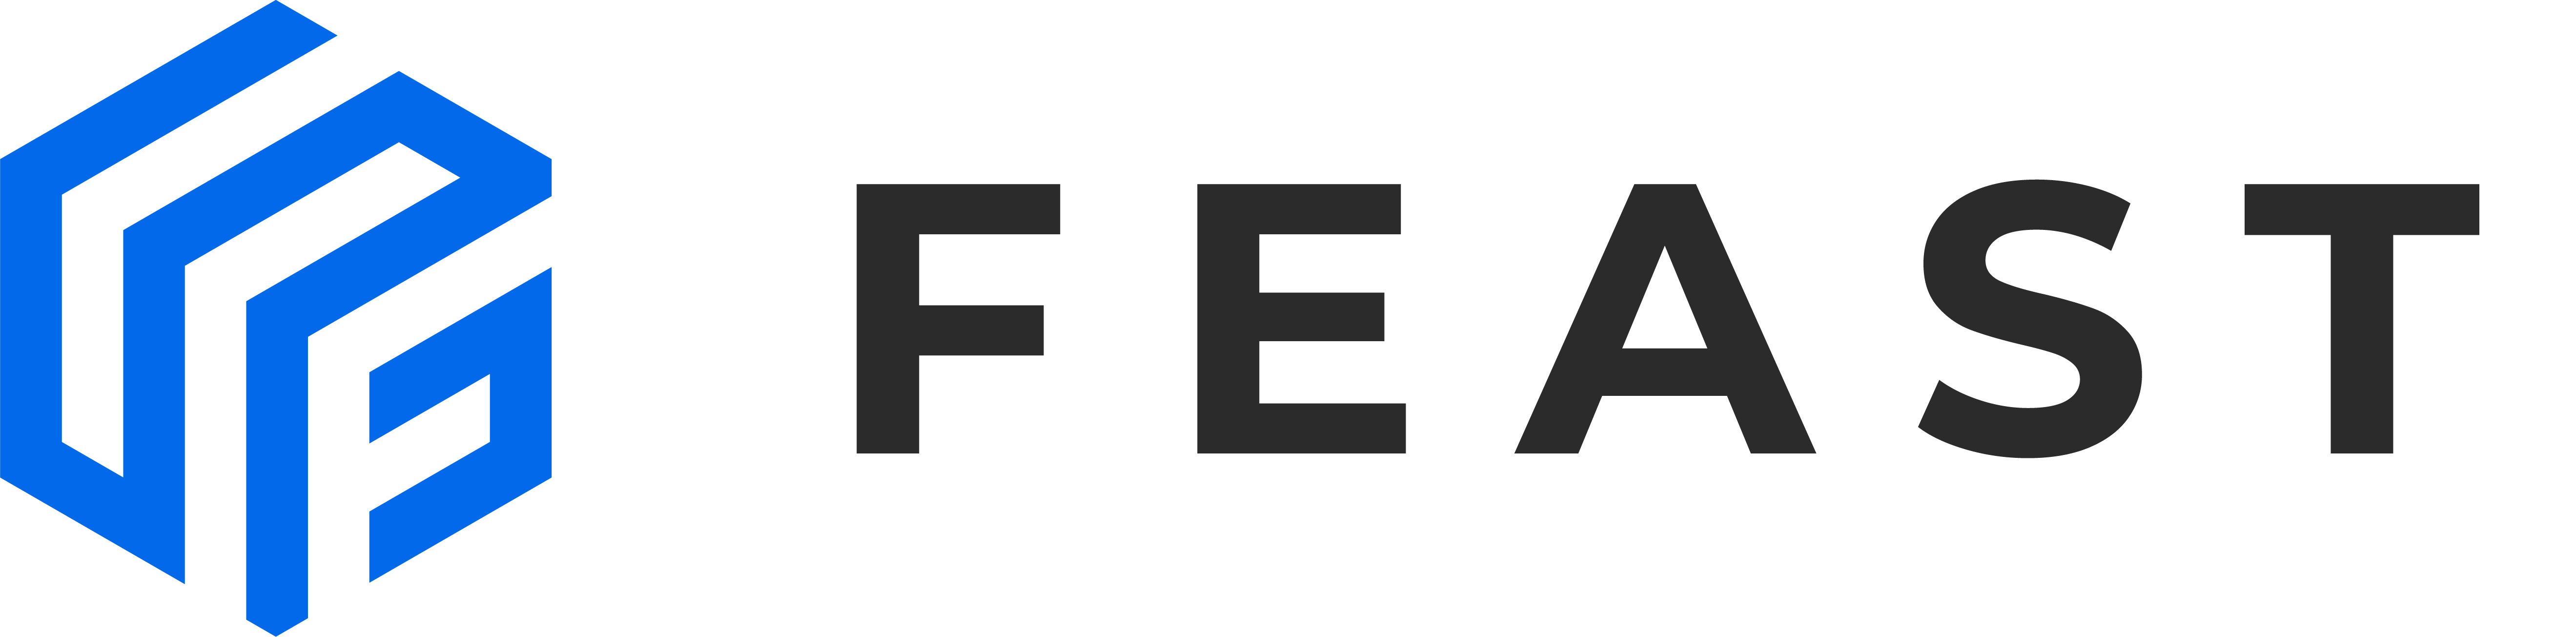

Feast (Feature Store) is an operational data system for managing and serving machine learning features to models in production.

[Git](https://github.com/feast-dev/feast)


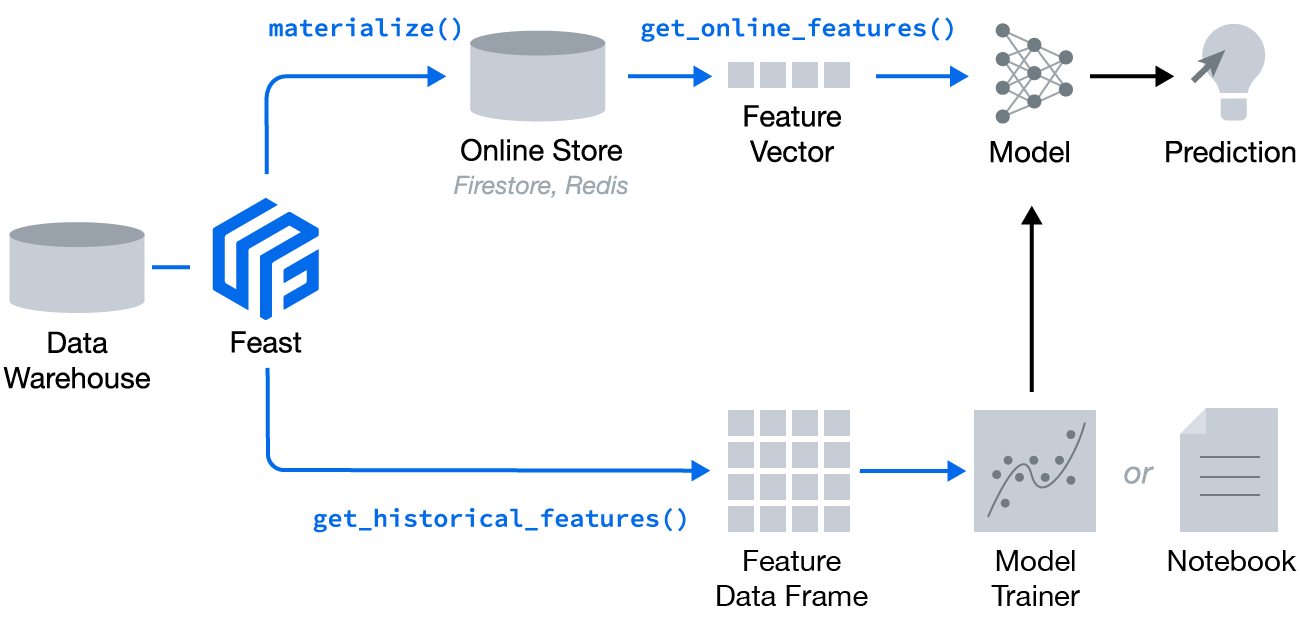

In [ ]:
!pip install -q feast

     |████████████████████████████████| 190 kB 5.1 MB/s 
     |████████████████████████████████| 100 kB 4.3 MB/s 
     |████████████████████████████████| 269 kB 9.8 MB/s 
     |████████████████████████████████| 10.1 MB 10.2 MB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 
     |████████████████████████████████| 2.3 MB 33.8 MB/s 


A feature repository is a directory that contains the configuration of the feature store and individual features. This configuration is written as code (Python/YAML) and it's highly recommended that teams track it centrally using git. 

Edit the example feature definitions in  example.py and run feast apply again to change feature definitions.

Feast uses a time-series data model to represent data. This data model is used to interpret feature data in data sources in order to build training datasets or when materializing features into an online store.
Below is an example data source with a single entity (driver) and two features (trips_today, and rating).

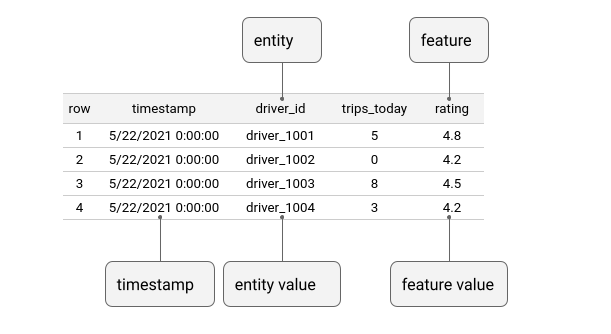

## Movielens

In [ ]:
!pip install -q git+https://github.com/sparsh-ai/recochef.git
from recochef.datasets.movielens import MovieLens

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.3MB 6.0MB/s 


### Load

In [ ]:
ml = MovieLens()
df = ml.load_interactions()
df.head()

### Transform

In [ ]:
from recochef.preprocessing import encode, split
train, test = split.chrono_split(df)
train, umap = encode.label_encode(train, col='USERID')
train, imap = encode.label_encode(train, col='ITEMID')
test = encode.label_encode(test, col='USERID', maps=umap)
test = encode.label_encode(test, col='ITEMID', maps=imap)
train.head()

### Create a feature repository

In [ ]:
!feast init my_movielens_repo
%cd my_movielens_repo


Creating a new Feast repository in /content/my_movielens_repo.

/content/my_movielens_repo


In [ ]:
train.to_parquet("./data/movielens_train.parquet")
test.to_parquet("./data/movielens_test.parquet")

In [ ]:
%%writefile example.py
from google.protobuf.duration_pb2 import Duration

from feast import Entity, Feature, FeatureView, ValueType
from feast.data_source import FileSource


movielens_train = FileSource(
    path="/content/my_movielens_repo/data/movielens_train.parquet",
    event_timestamp_column="datetime",
    created_timestamp_column="created",
)

movielens_test = FileSource(
    path="/content/my_movielens_repo/data/movielens_test.parquet",
    event_timestamp_column="datetime",
    created_timestamp_column="created",
)


itemid = Entity(name="ITEMID", value_type=ValueType.INT64, description="movie id")
userid = Entity(name="USERID", value_type=ValueType.INT64, description="user id")


movielens_train_view = FeatureView(
    name="movielens_train",
    entities=["itemid","userid"],
    ttl=Duration(seconds=86400 * 1),
    features=[
        Feature(name="RATING", dtype=ValueType.FLOAT),
        Feature(name="TIMESTAMP", dtype=ValueType.FLOAT),
    ],
    online=True,
    input=movielens_train,
    tags={},
)

movielens_test_view = FeatureView(
    name="movielens_test",
    entities=["itemid","userid"],
    ttl=Duration(seconds=86400 * 1),
    features=[
        Feature(name="RATING", dtype=ValueType.FLOAT),
        Feature(name="TIMESTAMP", dtype=ValueType.FLOAT),
    ],
    online=True,
    input=movielens_test,
    tags={},
)

Overwriting example.py


Register your feature definitions and set up your feature store

In [ ]:
!feast apply

Registered entity ITEMID
Registered entity USERID
Registered feature view movielens_test
Registered feature view movielens_train
Deploying infrastructure for movielens_test
Deploying infrastructure for movielens_train


### Build a training dataset

Feast allows users to build a training dataset from time-series feature data that already exists in an offline store. Users are expected to provide a list of features to retrieve (which may span multiple feature views), and a dataframe to join the resulting features onto. Feast will then execute a point-in-time join of multiple feature views onto the provided dataframe, and return the full resulting dataframe.

In [ ]:
train.sample(2)

,USERID,ITEMID,RATING,TIMESTAMP
2408,212,408,5.0,878955409
18737,390,53,5.0,877399659


In [ ]:
present_time

Timestamp('2021-07-09 08:49:27.205924+0000', tz='UTC')

In [ ]:
from feast import FeatureStore
import pandas as pd
from datetime import datetime

present_time = pd.Timestamp(datetime.now(), tz="UTC")

entity_df = pd.DataFrame.from_dict({
    "userid": [212, 390],
    "itemid": [408, 53],
    "datetime": [present_time,
                        present_time]
})

store = FeatureStore(repo_path=".")

training_df = store.get_historical_features(
    entity_df=entity_df, 
    feature_refs = [
        'movielens_train:RATING',
        # 'movielens_train:TIMESTAMP',
    ],
).to_df()

training_df

Using datetime as the event timestamp. To specify a column explicitly, please name it event_timestamp.


KeyError: ignored

In [ ]:
from feast import FeatureStore
import pandas as pd
from datetime import datetime

entity_df = pd.DataFrame.from_dict({
    "driver_id": [1001, 1002, 1003, 1004],
    "event_timestamp": [
        datetime(2021, 4, 12, 10, 59, 42),
        datetime(2021, 4, 12, 8,  12, 10),
        datetime(2021, 4, 12, 16, 40, 26),
        datetime(2021, 4, 12, 15, 1 , 12)
    ]
})

store = FeatureStore(repo_path=".")

training_df = store.get_historical_features(
    entity_df=entity_df, 
    feature_refs = [
        'driver_hourly_stats:conv_rate',
        'driver_hourly_stats:acc_rate',
        'driver_hourly_stats:avg_daily_trips'
    ],
).to_df()

In [ ]:
from feast import FeatureStore
import pandas as pd
from datetime import datetime

entity_df = pd.DataFrame.from_dict({
    "driver_id": [1001, 1002, 1003, 1004],
    "event_timestamp": [
        datetime(2021, 4, 12, 10, 59, 42),
        datetime(2021, 4, 12, 8,  12, 10),
        datetime(2021, 4, 12, 16, 40, 26),
        datetime(2021, 4, 12, 15, 1 , 12)
    ]
})

store = FeatureStore(repo_path=".")

training_df = store.get_historical_features(
    entity_df=entity_df, 
    feature_refs = [
        'driver_hourly_stats:conv_rate',
        'driver_hourly_stats:acc_rate',
        'driver_hourly_stats:avg_daily_trips'
    ],
).to_df()

In [ ]:
training_df.head()

,event_timestamp,driver_id,driver_hourly_stats__conv_rate,driver_hourly_stats__acc_rate,driver_hourly_stats__avg_daily_trips
0,2021-04-12 08:12:10+00:00,1002,0.385016,0.913230,803
1,2021-04-12 10:59:42+00:00,1001,0.192806,0.492017,973
2,2021-04-12 15:01:12+00:00,1004,0.371372,0.788611,837
3,2021-04-12 16:40:26+00:00,1003,0.828210,0.315526,205


### Load feature values into your online store

In [ ]:
%%sh
CURRENT_TIME=$(date -u +"%Y-%m-%dT%H:%M:%S")
feast materialize-incremental $CURRENT_TIME

Materializing 1 feature views to 2021-07-09 08:01:35+00:00 into the sqlite online store.

driver_hourly_stats from 2021-07-08 08:01:36+00:00 to 2021-07-09 08:01:35+00:00:


100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 455.73it/s]


### Read online features at low latency

In [ ]:
from pprint import pprint
from feast import FeatureStore

store = FeatureStore(repo_path=".")

feature_vector = store.get_online_features(
    feature_refs=[
        'driver_hourly_stats:conv_rate',
        'driver_hourly_stats:acc_rate',
        'driver_hourly_stats:avg_daily_trips'
    ],
    entity_rows=[{"driver_id": 1001}]
).to_dict()

pprint(feature_vector)  

{'driver_hourly_stats__acc_rate': [0.410092294216156],
 'driver_hourly_stats__avg_daily_trips': [870],
 'driver_hourly_stats__conv_rate': [0.8009825944900513],
 'driver_id': [1001]}


## Ad-click dataset

### Download the dataset

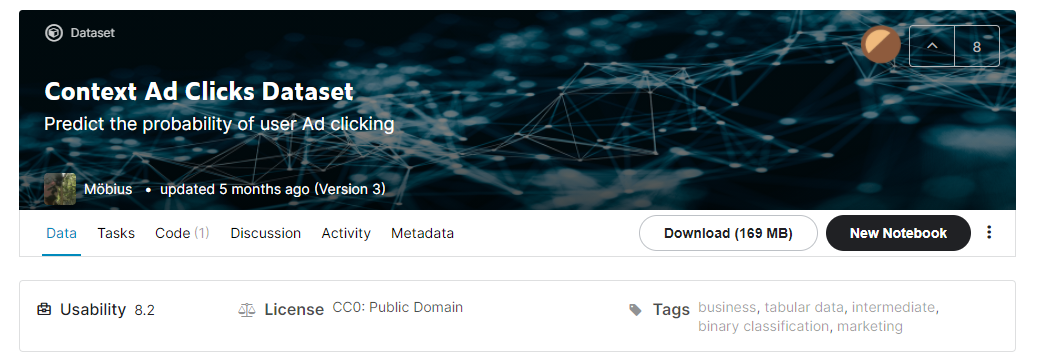

In [ ]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d arashnic/ctrtest
!unzip ctrtest

     |████████████████████████████████| 58 kB 2.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=ca2a0e775793c592ad857ea4c9e276cd1e6bef3d47d45182fbb83bb35cc8159c
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
 69% 25.0M/36.1M [00:00<00:00, 118MB/s]
100% 36.1M/36.1M [00:00<00:00, 146MB/s]
Archive:  ctrtest.zip
  inflating: sample_submission/sample_submission.csv  
  inflating: test_ctr/test.csv       
  inflating: train_adc/item_data.csv  
  inflating: train_adc/train.csv     
  inflating: train_adc/view_log.csv  


In [ ]:
import os
import pandas as pd
from datetime import datetime
from feast import FeatureStore
from feast import Entity, ValueType, Feature, FeatureView
from feast.data_format import ParquetFormat
from feast.data_source import FileSource
from google.protobuf.duration_pb2 import Duration

### Initializing the feature store

In [ ]:
!feast init click_data
%cd click_data


Creating a new Feast repository in /content/click_data.

/content/click_data


### ETL

In [ ]:
data = pd.read_csv("/content/train_adc/train.csv")
#Convert it to datetime before writing to quaaquet.
data['impression_time'] = pd.to_datetime(data['impression_time'])
data.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [ ]:
data.to_parquet("./data/train.parquet")

In [ ]:
item = pd.read_csv("/content/train_adc/item_data.csv")
item.to_parquet("./data/item_data.parquet")
item.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [ ]:
view_log = pd.read_csv("/content/train_adc/view_log.csv")
view_log['server_time'] = pd.to_datetime(view_log['server_time'])
view_log.to_parquet("./data/view_log.parquet")
view_log.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [ ]:
os.environ["TRAIN_DATA"] = "./data/view_log.parquet"
os.environ["ITEM_DATA"] = "./data/item_data.parquet"
os.environ["VIEW_LOG_DATA"] = "./data/view_log.parquet"

### Re-write the featureTable definition as feature store

In [ ]:
class ContextAdClickData:

    def __init__(self) -> None:
        self.features = {}

    def train_view_source(self):
        return FileSource(
            event_timestamp_column="impression_time",
                # created_timestamp_column="created",
            file_format=ParquetFormat(),
            path=os.environ.get("TRAIN_DATA"),
        )
    
    def item_data_view_source(self):
        return FileSource(
            file_format=ParquetFormat(),
            path=os.environ.get("ITEM_DATA")
            # path="s3://{bucket_name}/data/item_data.parquet"
        )
    
    def view_log_data_view_source(self):
        return FileSource(
            event_timestamp_column="server_time",
            file_format=ParquetFormat(),
            path=os.environ.get("VIEW_LOG_DATA")
        )

    def trainView(self):
        """Defines the train table for the click data.
        :params:
            - column_type_dict - A dictionary of columns and the data type
        
        """
        name = "train_table"
        return FeatureView(
            name=name,
            entities=[self.train_entity().name],
            ttl=Duration(seconds=86400 * 1),
            features=[
                self.feature_create("user_id", ValueType.STRING),
                self.feature_create("impression_id", ValueType.STRING),
                self.feature_create("app_code", ValueType.INT32),
                self.feature_create("os_version", ValueType.STRING),
                self.feature_create("is_4G", ValueType.INT32),
                self.feature_create("is_click", ValueType.INT32),
            ],
            online=True,
            input=self.train_view_source(),
            tags={}
        )
    
    def viewLogView(self):
        name = "view_log_table"
        return FeatureView(
            name=name,
            entities=[self.view_log_entity().name],
            ttl=Duration(seconds=86400 * 1),
            features=[
                # self.feature_create("server_time", ValueType.UNIX_TIMESTAMP),
                self.feature_create("device_type", ValueType.STRING),
                # self.feature_create("session_id", ValueType.INT32),
                self.feature_create("user_id", ValueType.INT64),
                self.feature_create("item_id", ValueType.INT64)
            ],
            online=True,
            input=self.view_log_data_view_source(),
            tags={}
        )

    def itemDataView(self):
        name = "item_data_table"
        feature_table = FeatureView(
            name=name,
            entities=[self.item_data_entity().name],
            ttl=Duration(seconds=86400 * 1),
            features=[
                self.feature_create("item_id", ValueType.INT32),
                self.feature_create("item_price", ValueType.INT32),
                self.feature_create("category_1", ValueType.INT32),
                self.feature_create("category_2", ValueType.INT32),
                self.feature_create("category_3", ValueType.INT32),
                self.feature_create("product_type", ValueType.INT32)
            ],
            online=True,
            input=self.item_data_view_source(),
            tags={}
        )
        return feature_table
        
    
    def train_entity(self):
        name = "impression_id"
        return Entity(name, value_type=ValueType.INT32, description="Impression logs with click details")

    def view_log_entity(self):
        name = "session_id"
        #TODO: Check how to merge the user_id in this entity and user id in click entity.
        return Entity(name=name, value_type=ValueType.INT64, description="View log containing user_id and item_id being viewed")
    
    def item_data_entity(self):
        name="item_id"
        return Entity(name=name, value_type=ValueType.INT32, description="Item data")

    def feature_create(self, name, value):
        """Add features """
        self.features[name] = Feature(name, dtype=value)
        assert name in self.features
        return self.features[name]

In [ ]:
addClick = ContextAdClickData()

en_train = addClick.train_entity()
en_item = addClick.item_data_entity()
en_view_log = addClick.view_log_entity()

x = addClick.trainView()
y = addClick.itemDataView()
z = addClick.viewLogView()

### Registering the features to local feature store

In [ ]:
store = FeatureStore(repo_path=".")

In [ ]:
store.apply([x,en_train])
# store.apply([y,en_item])
store.apply([z,en_view_log])

### Retrieving some features from local store

In [ ]:
entity_df = pd.DataFrame.from_dict({
    "session_id": [218564],
    "event_timestamp" : datetime(2018, 10, 15, 8, 58, 00),
})

In [ ]:
data_df = store.get_historical_features(feature_refs=["view_log_table:device_type"], entity_df=entity_df)
ex_data = data_df.to_df()
ex_data.head()

,event_timestamp,session_id,view_log_table__device_type
0,2018-10-15 08:58:00+00:00,218564,android
